# Price Prediction of OHLCV Time Series Data Using RNN's

This notebook is based on an example from Chapter 6, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).
The AlphaVantage wrapper code is from Kevin Johnson (twopirllc), using his own library pandas-ta as well.
Major credit to both Francois Chollet and Kevin Johnson for basically creating plug-and-play code.

---

This notebook was developed for the purpose of anlayzing OHLCV data for future values using a recurrent neural network.  The purpose of this book is not to create a trading bot, but rather to create an indicator for an automated system or manual trader to reference when desired.

If you're reading this, let me be super clear.  Recurrent neural networks are not the optimal way to attempt future prices of anything you're trading.  Be extremely cautious if you're considering implementing any of this in an actual strategy.  This is purely experimental and should be viewed as material of interest more than a useable resource.

A lot more can be extended from this simple framework, and many state of the art techniques have the potential to take this to a new level.  Future versions are intended to have GANs, autoencoders finding patterns we can't understand, bayesian hyperparameter space optimization, and much more.   

## The fundamental assumption

To apply this type of analysis, we make one fundamental assumption: that future price can be predicted to so degree based on patterns that can be extracted from time series analysis.  People have debated me on this, and I have one foot on each side of the fence, but it's a point to start from at least.

For implementation, we have chosen to pull free data from the AlphaVantage API and create a csv file locally with that data.

After that, we import the csv and read it into an array, then build an RNN model and fit it to our data.  Lots of room for experimentation in this region.  Consider altering the test/train split point, how big the batches are, etc.  Model layer design will also have varying degrees of improvement, but be advised - this will not be state of the art.

In [1]:
!pip install alphaVantage-api

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas_ta as ta
from alphaVantageAPI.alphavantage import AlphaVantage  # pip install alphaVantage-api

e = pd.DataFrame()

### Help on Indicators (post an [issue](https://github.com/twopirllc/pandas-ta/issues) if the indicator doc needs updating)

In [2]:
e.ta.indicators()
#help(ta.accbands)

pandas.ta - Technical Analysis Indicators
Total Indicators: 81
Abbreviations:
    accbands, ad, adosc, adx, ao, aobv, apo, aroon, atr, bbands, bop, cci, cmf, cmo, coppock, cross, decreasing, dema, donchian, dpo, efi, ema, eom, fwma, hl2, hlc3, hma, ichimoku, increasing, kc, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, percent_return, ppo, pvi, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, short_run, skew, sma, stdev, stoch, swma, t3, tema, trend_return, trima, trix, true_range, tsi, uo, variance, vortex, vp, vwap, vwma, willr, wma, zlma, zscore


### Load Data from [AlphaVantage](http://www.alphavantage.com) and clean it up a little

In [3]:
AV = AlphaVantage(
        api_key='44B7K1XT96231A5X',
        premium=False,       
        datatype='json',
        export=False,
        export_path= 'C:/Users/Andy/Documents/AVdata',
        output='csv',
        output_size='full',
        clean=True,
        proxy={})
#df = AV.fx(from_currency='USD', to_currency='EUR',  function='FX_Daily') # Daily
df = AV.data(function='D', symbol='SPY')
df.name = 'SPY'

last_ = df.shape[0]
print(f"Shape: {df.shape}")
df.set_index(['date'], inplace=True)
df.head()

Shape: (5363, 6)


,open,high,low,close,volume
date,,,,,
1998-01-02,97.3125,97.6562,96.5312,97.5625,2360900.0
1998-01-05,97.8437,98.4375,96.7812,97.7812,4191800.0
1998-01-06,97.2500,97.2812,96.1875,96.2187,3154900.0
1998-01-07,96.0937,96.7187,95.2187,96.4687,4424200.0
1998-01-08,96.3125,96.3125,95.3750,95.6250,3831000.0


In [4]:
list(df.columns.values)

['open', 'high', 'low', 'close', 'volume']

In [5]:
print(df)

                open      high       low     close       volume
date                                                           
1998-01-02   97.3125   97.6562   96.5312   97.5625    2360900.0
1998-01-05   97.8437   98.4375   96.7812   97.7812    4191800.0
1998-01-06   97.2500   97.2812   96.1875   96.2187    3154900.0
1998-01-07   96.0937   96.7187   95.2187   96.4687    4424200.0
1998-01-08   96.3125   96.3125   95.3750   95.6250    3831000.0
1998-01-09   95.2500   95.5000   91.9062   92.3125   10258800.0
1998-01-12   91.1250   94.1875   90.9062   94.0000   12097900.0
1998-01-13   94.6250   95.3750   94.2187   95.3125    5224900.0
1998-01-14   95.6875   95.9687   94.7187   95.7500    3770400.0
1998-01-15   95.5000   95.7500   94.8125   94.9531    2875400.0
1998-01-16   96.2500   96.6875   95.6562   96.3125    4374800.0
1998-01-20   96.6875   98.0156   96.5000   97.8750    5091700.0
1998-01-21   97.2187   97.6875   96.1562   96.9375    4699400.0
1998-01-22   96.1562   96.8750   95.8750

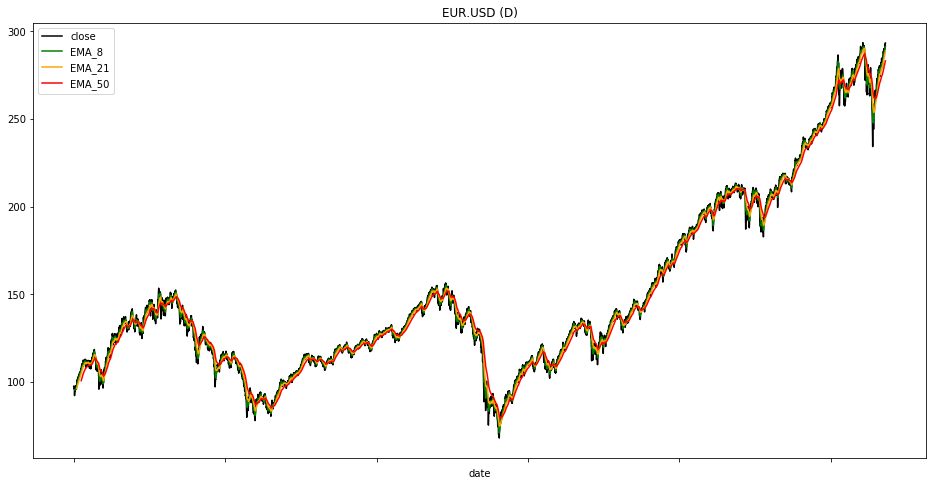

In [6]:
df.ta.ema(length=8, append=True)
df.ta.ema(length=21, append=True)
df.ta.ema(length=50, append=True)

df[['close', 'EMA_8', 'EMA_21', 'EMA_50']].plot(figsize=(16,8), color=['black', 'green', 'orange', 'red'], title="EUR.USD (D)")

In [7]:
#pd.DataFrame().ta.indicators()
#help(pd.DataFrame().ta)

In [8]:
#Momentum Indicators
df.ta.ao(append=True)
df.ta.apo(append=True)
df.ta.bop(append=True)
df.ta.cci(append=True)
df.ta.cmo(append=True)
df.ta.coppock(append=True)
df.ta.kst(append=True)
df.ta.macd(append=True)
df.ta.mom(append=True)
df.ta.ppo(append=True)
df.ta.roc(append=True)
df.ta.rsi(append=True)
df.ta.stoch(append=True)
df.ta.trix(append=True)
df.ta.tsi(append=True)
df.ta.uo(append=True)
df.ta.willr(append=True)

date
1998-01-02          NaN
1998-01-05          NaN
1998-01-06          NaN
1998-01-07          NaN
1998-01-08          NaN
1998-01-09          NaN
1998-01-12          NaN
1998-01-13          NaN
1998-01-14          NaN
1998-01-15          NaN
1998-01-16          NaN
1998-01-20          NaN
1998-01-21          NaN
1998-01-22   -31.327925
1998-01-23   -33.194800
1998-01-26   -30.109433
1998-01-27   -16.483810
1998-01-28    -5.422665
1998-01-29   -15.162367
1998-01-30   -14.440350
1998-02-02    -8.955153
1998-02-03    -2.051265
1998-02-04    -9.358891
1998-02-05   -16.587045
1998-02-06     0.000000
1998-02-09    -6.945185
1998-02-10    -2.928220
1998-02-11    -4.184128
1998-02-12    -4.564949
1998-02-13   -12.875448
                ...    
2019-03-15   -10.742972
2019-03-18    -3.222656
2019-03-19   -16.415410
2019-03-20   -23.534338
2019-03-21    -3.526646
2019-03-22   -46.473354
2019-03-25   -48.119122
2019-03-26   -31.818182
2019-03-27   -43.338558
2019-03-28   -44.924623
2019-03-29 

In [9]:
#Overlap Indicators
df.ta.dema(append=True)
df.ta.ema(length=8, append=True)
df.ta.ema(length=21, append=True)
df.ta.ema(length=50, append=True)
df.ta.fwma(append=True)
df.ta.hl2(append=True)
df.ta.hlc3(append=True)
df.ta.hma(append=True)
df.ta.linreg(append=True)
df.ta.midpoint(append=True)
df.ta.midprice(append=True)
df.ta.ohlc4(append=True)
df.ta.pwma(append=True)
df.ta.rma(append=True)
df.ta.sma(append=True)
df.ta.t3(append=True)
df.ta.tema(append=True)
df.ta.trima(append=True)
df.ta.wma(append=True)

date
1998-01-02           NaN
1998-01-05           NaN
1998-01-06           NaN
1998-01-07           NaN
1998-01-08           NaN
1998-01-09           NaN
1998-01-12           NaN
1998-01-13           NaN
1998-01-14           NaN
1998-01-15     95.117033
1998-01-16     95.246865
1998-01-20     95.683516
1998-01-21     95.948007
1998-01-22     96.043175
1998-01-23     96.119880
1998-01-26     96.179540
1998-01-27     96.350555
1998-01-28     96.628956
1998-01-29     96.960209
1998-01-30     97.257371
1998-02-02     97.788907
1998-02-03     98.390898
1998-02-04     98.919025
1998-02-05     99.369880
1998-02-06     99.944882
1998-02-09    100.353965
1998-02-10    100.840900
1998-02-11    101.212484
1998-02-12    101.582931
1998-02-13    101.766456
                 ...    
2019-03-15    279.329091
2019-03-18    279.989818
2019-03-19    280.610000
2019-03-20    281.014182
2019-03-21    281.919818
2019-03-22    281.652364
2019-03-25    281.259636
2019-03-26    281.234182
2019-03-27    280.91

In [10]:
#Statistics Indicators
df.ta.kurtosis(append=True)
df.ta.median(append=True)
df.ta.quantile(append=True)
df.ta.skew(append=True)
df.ta.stdev(append=True)
df.ta.variance(append=True)
df.ta.zscore(append=True)

date
1998-01-02         NaN
1998-01-05         NaN
1998-01-06         NaN
1998-01-07         NaN
1998-01-08         NaN
1998-01-09         NaN
1998-01-12         NaN
1998-01-13         NaN
1998-01-14         NaN
1998-01-15         NaN
1998-01-16         NaN
1998-01-20         NaN
1998-01-21         NaN
1998-01-22         NaN
1998-01-23         NaN
1998-01-26         NaN
1998-01-27         NaN
1998-01-28         NaN
1998-01-29         NaN
1998-01-30         NaN
1998-02-02         NaN
1998-02-03         NaN
1998-02-04         NaN
1998-02-05         NaN
1998-02-06         NaN
1998-02-09         NaN
1998-02-10         NaN
1998-02-11         NaN
1998-02-12         NaN
1998-02-13    1.457398
                ...   
2019-03-15    1.324126
2019-03-18    1.523413
2019-03-19    1.442908
2019-03-20    1.125119
2019-03-21    1.859696
2019-03-22    0.286316
2019-03-25    0.152418
2019-03-26    0.845837
2019-03-27    0.217874
2019-03-28    0.607048
2019-03-29    1.333798
2019-04-01    2.475058
2019-0

In [11]:
#Trend Indicators
df.ta.adx(append=True)
df.ta.aroon(append=True)
df.ta.decreasing(append=True)
df.ta.dpo(append=True)
df.ta.increasing(append=True)
df.ta.vortex(append=True)

,VTXP_14,VTXM_14
date,,
1998-01-02,NaN,NaN
1998-01-05,NaN,NaN
1998-01-06,NaN,NaN
1998-01-07,NaN,NaN
1998-01-08,NaN,NaN
1998-01-09,NaN,NaN
1998-01-12,NaN,NaN
1998-01-13,NaN,NaN
1998-01-14,NaN,NaN


In [12]:
#Volatility Indicators
df.ta.accbands(append=True)
df.ta.atr(append=True)
df.ta.bbands(append=True)
df.ta.donchian(append=True)
df.ta.kc(append=True)
df.ta.natr(append=True)
df.ta.true_range(append=True)

date
1998-01-02    1.1250
1998-01-05    1.6563
1998-01-06    1.5937
1998-01-07    1.5000
1998-01-08    1.0937
1998-01-09    3.7188
1998-01-12    3.2813
1998-01-13    1.3750
1998-01-14    1.2500
1998-01-15    0.9375
1998-01-16    1.7344
1998-01-20    1.7031
1998-01-21    1.7188
1998-01-22    1.0625
1998-01-23    1.7812
1998-01-26    1.3281
1998-01-27    1.8438
1998-01-28    1.2656
1998-01-29    2.0000
1998-01-30    0.9687
1998-02-02    2.1875
1998-02-03    1.0938
1998-02-04    1.2187
1998-02-05    1.5625
1998-02-06    1.1250
1998-02-09    1.0313
1998-02-10    1.2812
1998-02-11    0.6406
1998-02-12    2.0625
1998-02-13    0.7187
               ...  
2019-03-15    1.8800
2019-03-18    1.3600
2019-03-19    2.9500
2019-03-20    3.1800
2019-03-21    4.5900
2019-03-22    5.5500
2019-03-25    2.5453
2019-03-26    3.1400
2019-03-27    3.8300
2019-03-28    2.1400
2019-03-29    2.1300
2019-04-01    3.6800
2019-04-02    1.1400
2019-04-03    2.0100
2019-04-04    1.4490
2019-04-05    1.4500
2019-04-

In [13]:
#Volume Indicators
df.ta.ad(append=True)
df.ta.adosc(append=True)
df.ta.cmf(append=True)
df.ta.efi(append=True)
df.ta.eom(append=True)
df.ta.mfi(append=True)
df.ta.nvi(append=True)
df.ta.obv(append=True)
df.ta.pvol(append=True)
df.ta.pvt(append=True)
df.ta.vp(append=True)

,high_close,low_close,mean_close,neg_volume,pos_volume,total_volume
0,147.0000,92.3125,122.143547,1.668673e+09,2.284998e+09,3.953671e+09
1,153.5625,97.2800,128.450728,2.729617e+09,3.689279e+09,6.418896e+09
2,116.3800,78.1000,99.219553,9.738802e+09,1.220050e+10,2.193930e+10
3,132.6200,106.8500,120.701996,1.383085e+10,1.756378e+10,3.139463e+10
4,156.4800,120.9900,140.540297,3.952227e+10,4.779576e+10,8.731803e+10
5,127.9200,68.1100,102.001925,6.157515e+10,8.053335e+10,1.421085e+11
6,147.2400,109.9300,131.110645,4.221111e+10,5.406981e+10,9.628091e+10
7,208.7200,140.0300,178.255763,2.938781e+10,3.378182e+10,6.316962e+10
8,239.7800,182.8600,209.947395,2.558007e+10,3.313706e+10,5.871713e+10
9,293.5800,232.5100,264.397108,1.912578e+10,2.571330e+10,4.483908e+10


In [14]:
list(df.columns.values)

['open',
 'high',
 'low',
 'close',
 'volume',
 'EMA_8',
 'EMA_21',
 'EMA_50',
 'AO_5_34',
 'APO_12_26',
 'BOP',
 'CCI_20_0.015',
 'CMO_14',
 'COPC_11_14_10',
 'KST_10_15_20_30_10_10_10_15',
 'KSTS_9',
 'MACD_12_26_9',
 'MACDH_12_26_9',
 'MACDS_12_26_9',
 'MOM_10',
 'PPO_12_26_9',
 'PPOH_12_26_9',
 'PPOS_12_26_9',
 'ROC_10',
 'RSI_14',
 'STOCHF_14',
 'STOCHF_3',
 'STOCH_5',
 'STOCH_3',
 'TRIX_30',
 'TSI_13_25',
 'UO_7_14_28',
 'WILLR_14',
 'DEMA_10',
 'FWMA_10',
 'HL2',
 'HLC3',
 'HMA_10',
 'LR_14',
 'MIDPOINT_2',
 'MIDPRICE_2',
 'OHLC4',
 'PWMA_10',
 'RMA_10',
 'SMA_10',
 'T3_10_0.7',
 'TEMA_10',
 'TRIMA_10',
 'WMA_10',
 'KURT_30',
 'MEDIAN_30',
 'QTL_30_0.5',
 'SKEW_30',
 'STDEV_30',
 'VAR_30',
 'Z_30',
 'ADX_14',
 'DMP_14',
 'DMN_14',
 'AROOND_14',
 'AROONU_14',
 'DEC_1',
 'DPO_1',
 'INC_1',
 'VTXP_14',
 'VTXM_14',
 'ACCBL_20',
 'ACCBM_20',
 'ACCBU_20',
 'ATR_14',
 'BBL_20',
 'BBM_20',
 'BBU_20',
 'DCL_10_20',
 'DCM_10_20',
 'DCU_10_20',
 'KCL_20',
 'KCB_20',
 'KCU_20',
 'NATR_14',


In [15]:
print(f"Shape: {df.shape}")

Shape: (5363, 91)


In [16]:
df.head()

,open,high,low,close,volume,EMA_8,EMA_21,EMA_50,AO_5_34,APO_12_26,...,AD,ADOSC_12_26,CMF_20,EFI_13,EOM_14_100000000,MFI_14,NVI_1,OBV,PVOL,PVT
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,97.3125,97.6562,96.5312,97.5625,2360900.0,NaN,NaN,NaN,NaN,NaN,...,1.967627e+06,NaN,NaN,NaN,NaN,NaN,1000.000000,2360900.0,2.303353e+08,NaN
1998-01-05,97.8437,98.4375,96.7812,97.7812,4191800.0,NaN,NaN,NaN,NaN,NaN,...,2.837470e+06,NaN,NaN,NaN,NaN,NaN,1000.000000,6552700.0,4.098792e+08,9.396506e+05
1998-01-06,97.2500,97.2812,96.1875,96.2187,3154900.0,NaN,NaN,NaN,NaN,NaN,...,-1.374303e+05,NaN,NaN,NaN,NaN,NaN,998.402045,3397800.0,3.035604e+08,-4.101739e+06
1998-01-07,96.0937,96.7187,95.2187,96.4687,4424200.0,NaN,NaN,NaN,NaN,NaN,...,2.812036e+06,NaN,NaN,NaN,NaN,NaN,998.402045,7822000.0,4.267968e+08,-2.952222e+06
1998-01-08,96.3125,96.3125,95.3750,95.6250,3831000.0,NaN,NaN,NaN,0.0,NaN,...,1.024236e+06,NaN,NaN,NaN,NaN,NaN,997.527460,3991000.0,3.663394e+08,-6.302754e+06


### Load Data from [AlphaVantage](http://www.alphavantage.com) and clean it up a little

In [17]:
df.fillna(0.0, inplace=True)
df.head()

,open,high,low,close,volume,EMA_8,EMA_21,EMA_50,AO_5_34,APO_12_26,...,AD,ADOSC_12_26,CMF_20,EFI_13,EOM_14_100000000,MFI_14,NVI_1,OBV,PVOL,PVT
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,97.3125,97.6562,96.5312,97.5625,2360900.0,0.0,0.0,0.0,0.0,0.0,...,1.967627e+06,0.0,0.0,0.0,0.0,0.0,1000.000000,2360900.0,2.303353e+08,0.000000e+00
1998-01-05,97.8437,98.4375,96.7812,97.7812,4191800.0,0.0,0.0,0.0,0.0,0.0,...,2.837470e+06,0.0,0.0,0.0,0.0,0.0,1000.000000,6552700.0,4.098792e+08,9.396506e+05
1998-01-06,97.2500,97.2812,96.1875,96.2187,3154900.0,0.0,0.0,0.0,0.0,0.0,...,-1.374303e+05,0.0,0.0,0.0,0.0,0.0,998.402045,3397800.0,3.035604e+08,-4.101739e+06
1998-01-07,96.0937,96.7187,95.2187,96.4687,4424200.0,0.0,0.0,0.0,0.0,0.0,...,2.812036e+06,0.0,0.0,0.0,0.0,0.0,998.402045,7822000.0,4.267968e+08,-2.952222e+06
1998-01-08,96.3125,96.3125,95.3750,95.6250,3831000.0,0.0,0.0,0.0,0.0,0.0,...,1.024236e+06,0.0,0.0,0.0,0.0,0.0,997.527460,3991000.0,3.663394e+08,-6.302754e+06


In [18]:
df.tail

<bound method NDFrame.tail of                 open      high       low     close       volume       EMA_8  \
date                                                                          
1998-01-02   97.3125   97.6562   96.5312   97.5625    2360900.0    0.000000   
1998-01-05   97.8437   98.4375   96.7812   97.7812    4191800.0    0.000000   
1998-01-06   97.2500   97.2812   96.1875   96.2187    3154900.0    0.000000   
1998-01-07   96.0937   96.7187   95.2187   96.4687    4424200.0    0.000000   
1998-01-08   96.3125   96.3125   95.3750   95.6250    3831000.0    0.000000   
1998-01-09   95.2500   95.5000   91.9062   92.3125   10258800.0    0.000000   
1998-01-12   91.1250   94.1875   90.9062   94.0000   12097900.0    0.000000   
1998-01-13   94.6250   95.3750   94.2187   95.3125    5224900.0   95.660138   
1998-01-14   95.6875   95.9687   94.7187   95.7500    3770400.0   95.680107   
1998-01-15   95.5000   95.7500   94.8125   94.9531    2875400.0   95.518550   
1998-01-16   96.2500  

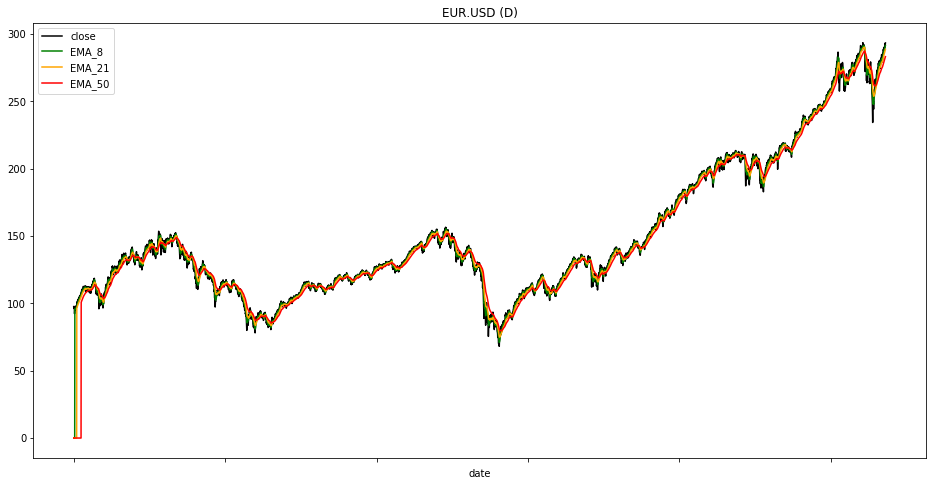

In [19]:
df[['close', 'EMA_8', 'EMA_21', 'EMA_50']].plot(figsize=(16,8), color=['black', 'green', 'orange', 'red'], title="EUR.USD (D)")

In [20]:
df.to_csv (r'C:\Users\Andy\Documents\AVdata\FXDtest1.csv', index = 'date', header=True) 

Let's import our data.  You'll need to update data_dir to an actual folder on your local machine.

In [1]:
import os

data_dir = 'C:/Users/Andy/Documents/AVdata/' #make sure to put the / character
fname = os.path.join(data_dir, 'FXDtest1.csv') #make sure you have the name of the csv file correct

f = open(fname) #open the csv
data = f.read() #read in the data
f.close()       #close the csv file - we don't have to keep the file in use for this

lines = data.split('\n') #create the lines of data in the table
header = lines[0].split(',') #create the headers of the table

lines = lines[1:] #lines from 1 to the end of the data

print(header) #shows us all of the header titles in our table of OHLCV + Indicators
print(len(lines)) #shows us how many rows of data we have

['date', 'open', 'high', 'low', 'close', 'volume', 'EMA_8', 'EMA_21', 'EMA_50', 'AO_5_34', 'APO_12_26', 'BOP', 'CCI_20_0.015', 'CMO_14', 'COPC_11_14_10', 'KST_10_15_20_30_10_10_10_15', 'KSTS_9', 'MACD_12_26_9', 'MACDH_12_26_9', 'MACDS_12_26_9', 'MOM_10', 'PPO_12_26_9', 'PPOH_12_26_9', 'PPOS_12_26_9', 'ROC_10', 'RSI_14', 'STOCHF_14', 'STOCHF_3', 'STOCH_5', 'STOCH_3', 'TRIX_30', 'TSI_13_25', 'UO_7_14_28', 'WILLR_14', 'DEMA_10', 'FWMA_10', 'HL2', 'HLC3', 'HMA_10', 'LR_14', 'MIDPOINT_2', 'MIDPRICE_2', 'OHLC4', 'PWMA_10', 'RMA_10', 'SMA_10', 'T3_10_0.7', 'TEMA_10', 'TRIMA_10', 'WMA_10', 'KURT_30', 'MEDIAN_30', 'QTL_30_0.5', 'SKEW_30', 'STDEV_30', 'VAR_30', 'Z_30', 'ADX_14', 'DMP_14', 'DMN_14', 'AROOND_14', 'AROONU_14', 'DEC_1', 'DPO_1', 'INC_1', 'VTXP_14', 'VTXM_14', 'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'ATR_14', 'BBL_20', 'BBM_20', 'BBU_20', 'DCL_10_20', 'DCM_10_20', 'DCU_10_20', 'KCL_20', 'KCB_20', 'KCU_20', 'NATR_14', 'TRUERANGE_1', 'AD', 'ADOSC_12_26', 'CMF_20', 'EFI_13', 'EOM_14_1000000

Let's convert all of this data into a Numpy array:

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    if len(line.split(",")) > 1: #last line doesn't have a comma, so this is why
        #print(i)
        values = [float(x) for x in line.split(',')[1:]]
        float_data[i, :] = values
        
print("numpy creation success")

numpy creation success


Let's plot the close price over time.

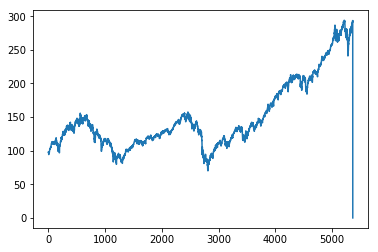

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

close = float_data[:,1]  # close price values over time
plt.plot(range(len(close)), close)
plt.show()

Here is a way to view the plot where you can edit which rows of data to report (i.e. what period of time to look at).

Note that I have removed the last data point in the series so the graph is easier to interpret.

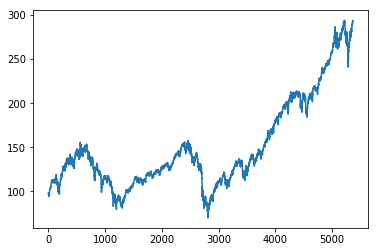

In [4]:
plt.plot(range(5363), close[:5363])
plt.show()

Next we have to prepare the data to be fed into the RNN.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 1 minute) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 240`, i.e. our observations will go back 4 hours.
* `steps = 10`, i.e. our observations will be sampled at one data point per 10 minutes.
* `delay = 60`, i.e. our targets will be 1 hour in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [2]:
2+2

4

In [5]:
mean = float_data[:2500].mean(axis=0)
float_data -= mean
print(float_data)

[[-2.40079397e+01 -2.44794719e+01 -2.38373502e+01 ... -7.99217110e+08
  -5.23707220e+09 -9.13601041e+07]
 [-2.34767397e+01 -2.36981719e+01 -2.35873502e+01 ... -7.95025310e+08
  -5.05752827e+09 -9.04204535e+07]
 [-2.40704397e+01 -2.48544719e+01 -2.41810502e+01 ... -7.98180210e+08
  -5.16384713e+09 -9.54618431e+07]
 ...
 [ 1.70799560e+02  1.70644328e+02  1.70361450e+02 ...  8.14848910e+09
   1.14045727e+10 -3.78445525e+10]
 [ 1.70779560e+02  1.71354328e+02  1.70871550e+02 ...  8.19937770e+09
   9.46381662e+09 -3.78208550e+10]
 [-1.21320440e+02 -1.22135672e+02 -1.20368550e+02 ... -8.01578010e+08
  -5.46740750e+09 -9.13601041e+07]]


In [6]:
mean[3]

121.27912979999965

In [7]:
std = float_data[:2500].std(axis=0)
print(std[3])

17.62146210135775


In [8]:
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [9]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=120, step=4):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [11]:
lookback = 1200
step = 4
delay = 10
batch_size = 120

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2500,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=2501,
                    max_index=4000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=4001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (4000 - 2501 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 4001 - lookback) // batch_size

Here's our evaluation loop:

It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

In [12]:
mean[3] #mean of close price in dollars

121.27912979999965

In [13]:
std[3]

17.62146210135775

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [748]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.CuDNNLSTM(256,
                     #return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
#model.add(layers.Dense(128))                          
model.add(layers.Dense(1))


model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/60
20/20 [==============================] - 5s 233ms/step - loss: 0.3999 - val_loss: 0.6170
Epoch 2/60
20/20 [==============================] - 1s 73ms/step - loss: 0.2006 - val_loss: 0.7335
Epoch 3/60
20/20 [==============================] - 2s 87ms/step - loss: 0.1686 - val_loss: 0.6396
Epoch 4/60
20/20 [==============================] - 2s 83ms/step - loss: 0.1445 - val_loss: 0.9080
Epoch 5/60
20/20 [==============================] - 2s 86ms/step - loss: 0.1250 - val_loss: 0.7053
Epoch 6/60
20/20 [==============================] - 2s 86ms/step - loss: 0.1197 - val_loss: 0.7316
Epoch 7/60
20/20 [==============================] - 2s 84ms/step - loss: 0.1049 - val_loss: 0.6055
Epoch 8/60
20/20 [==============================] - 2s 84ms/step - loss: 0.1040 - val_loss: 0.6508
Epoch 9/60
20/20 [==============================] - 1s 73ms/step - loss: 0.0920 - val_loss: 0.6810
Epoch 10/60
20/20 [==============================] - 2s 87ms/step - loss: 0.0881 - val_loss: 0.6497
Epoch 11

Let look at our results:

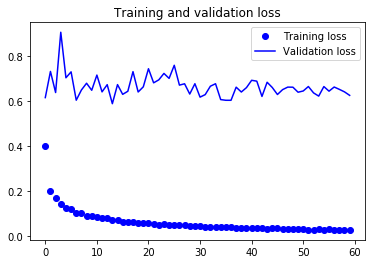

In [749]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print("accuracy of prediction within",min(val_loss)*std[3],"dollars")

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(48,
                     dropout=0.15,
                     recurrent_dropout=0.15,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print("accuracy of prediction within",val_loss[59]*std[3],"dollars")

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.CuDNNGRU(64,
                     #dropout=0.1,
                     #recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.CuDNNGRU(64,
                     input_shape=(None, float_data.shape[-1])))
                          #activation='relu'))
                     #dropout=0.1, 
                     #recurrent_dropout=0.5))
                    
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Let's take a look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
print("accuracy of prediction within",val_loss[59]*std[3],"dollars")

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss 
improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this 
point.


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* As you first learned in Chapter 4, when approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.